In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
linux_records = pd.read_csv(r"C:\Users\Calin PC\Documents\Proiecte\linux_monitoring_project\data\linux_records.csv")
linux_records.head()

,record_timestamp,devtmpfs,sda1,cs_root,tmpfs_root,usr,nice,sys,iowait,irq,...,idle,mem_total,mem_used,mem_free,mem_shared,mem_buffcached,mem_available,swap_total,swap_used,swap_free
0,2024-02-26 00:00:00.000000,0,285102,4541382,285102,4.99,0.04,3.66,1.00,0,...,85.93,3747104,2886839,860265,2875,1179117,860265,1048572,7681,1040891
1,2024-02-26 00:00:05.000000,0,285435,4540378,285435,5.00,0.03,3.62,1.00,0,...,86.01,3747104,2695827,1051277,2718,1178458,1051277,1048572,7617,1040955
2,2024-02-26 00:00:10.000000,0,285860,4543489,285860,4.90,0.04,3.66,0.98,0,...,86.02,3747104,2636430,1110674,2509,1175987,1110674,1048572,7440,1041132
3,2024-02-26 00:00:15.000000,0,285270,4544200,285270,4.94,0.02,3.68,0.99,0,...,85.96,3747104,2821646,925458,2948,1172858,925458,1048572,7210,1041362
4,2024-02-26 00:00:20.000000,0,285106,4544871,285106,4.94,0.03,3.68,0.99,0,...,85.94,3747104,2238745,1508359,2584,1177299,1508359,1048572,7618,1040954


 Convert record_timestamp to datetime format

In [4]:
linux_records['record_timestamp'] = pd.to_datetime(linux_records['record_timestamp'])
len(linux_records.index)

483840

Check if there are column with negative values and with no values

In [5]:
columns_with_negative_values = linux_records.drop(columns='record_timestamp').columns[(linux_records.drop(columns='record_timestamp') < 0).any()]
columns_with_negative_values

Index(['idle'], dtype='object')

In [6]:
empty_columns = linux_records.columns[linux_records.isna().all()]
empty_columns

Index([], dtype='object')

# Analyzing 'idle' column because its negative values:
- Histogram
- Boxplot
- Statistics
- Potential impact on other metrics 

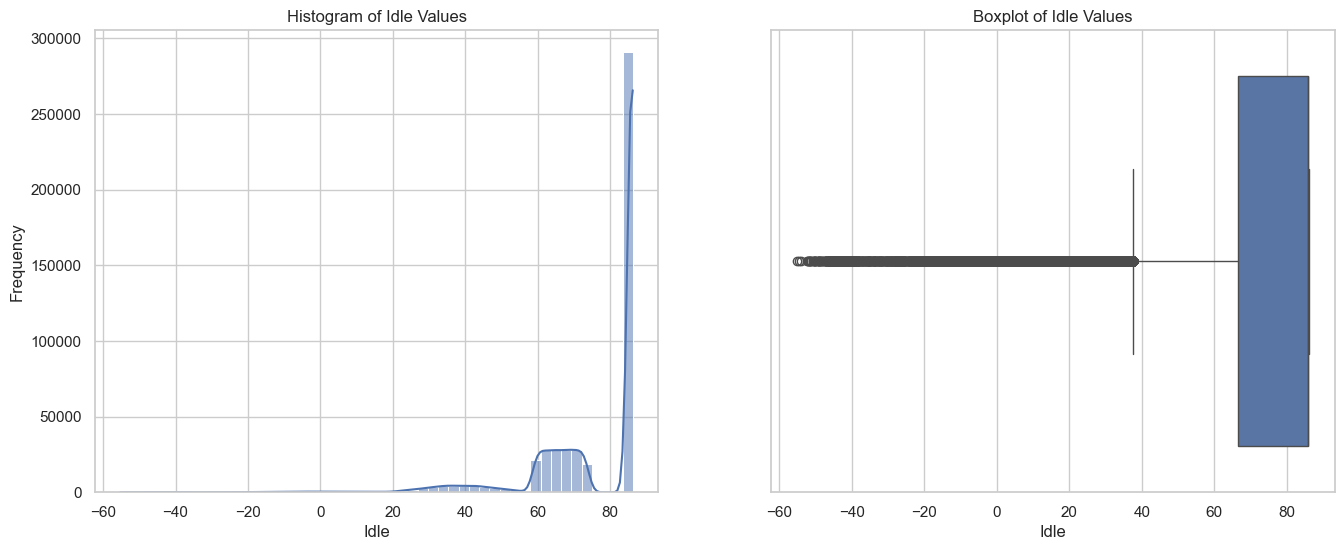

In [7]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1,2, figsize=(16,6))

# histogram for 'idle'
sns.histplot(linux_records['idle'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Idle Values')
ax[0].set_xlabel('Idle')
ax[0].set_ylabel('Frequency')

# boxplot for 'idle'
sns.boxplot(x=linux_records['idle'], ax=ax[1])
ax[1].set_title('Boxplot of Idle Values')
ax[1].set_xlabel('Idle')

plt.show()


The histogram shows the distribution of values ​​for idle. We notice that most of the values ​​are positive and clustered around a central value, with a fairly symmetrical distribution. Negative values ​​represent obvious anomalies on this distribution.

The boxplot highlights the presence of negative values ​​as outliers below the lower bound of the plots. These negative values ​​are quite far from the rest of the distribution, making them easily identifiable as anomalies.

To analyze the relationship between idle and the other metrics in the data set, we can use several methods:
- Correlation: We calculate the correlation coefficient to see how strongly the idle value is associated with other metrics. This can provide an overview of possible links between idle and system performance or other parameters.
- Scatter Plots: We make scatter plots between idle and other selected metrics to visualize relationships. This can help identify trends, correlations or unusual patterns of variation.
 


I will only calculate the correlation for the first 10,000 rows to get a general idea of ​​the possible relationships

In [8]:
subset_correlation_matrix = linux_records.iloc[:10000].corr()
subset_idle_correlations = subset_correlation_matrix['idle'].sort_values()
subset_idle_correlations

soft               -0.996876
sys                -0.982444
iowait             -0.964722
mem_used           -0.015390
usr                -0.011892
swap_free          -0.007370
tmpfs_root         -0.004651
sda1               -0.004651
nice               -0.000979
record_timestamp    0.000818
mem_buffcached      0.004740
mem_shared          0.006335
swap_used           0.007370
cs_root             0.008765
mem_free            0.015390
mem_available       0.015390
idle                1.000000
devtmpfs                 NaN
irq                      NaN
steal                    NaN
guest                    NaN
mem_total                NaN
swap_total               NaN
Name: idle, dtype: float64

Strongly Negative Correlations:
- soft
- sys
- iowait

That indicates that an increase in metrics from above is associated with a decrease in idle percentage. This is expected because higher CPU utilization for software, system or I/O wait tasks reduces the amount of time the CPU is idle.

Reduced Correlations:
- mem_used
- usr
- swap_free
- tmpfs_root
- sda1
- nice
- record_timestamp
- mem_buffcached
- mem_shared
- swap_used
- cs_root
- mem_free
- mem_available

That suggests that these metrics do not directly influence CPU idle time significantly.

Without Correlation:
- devtmpfs
- irq
- steal 
- guest
- mem_total
- swap_total

It means that there is no variation in these data or they are constant and no correlation can be calculated.


We can explore the strongly negative relationships in more detail via scatterplots to visualize how idle varies by soft, sys, and iowait. We can also investigate whether these metrics could be useful for detecting anomalies in system behavior.

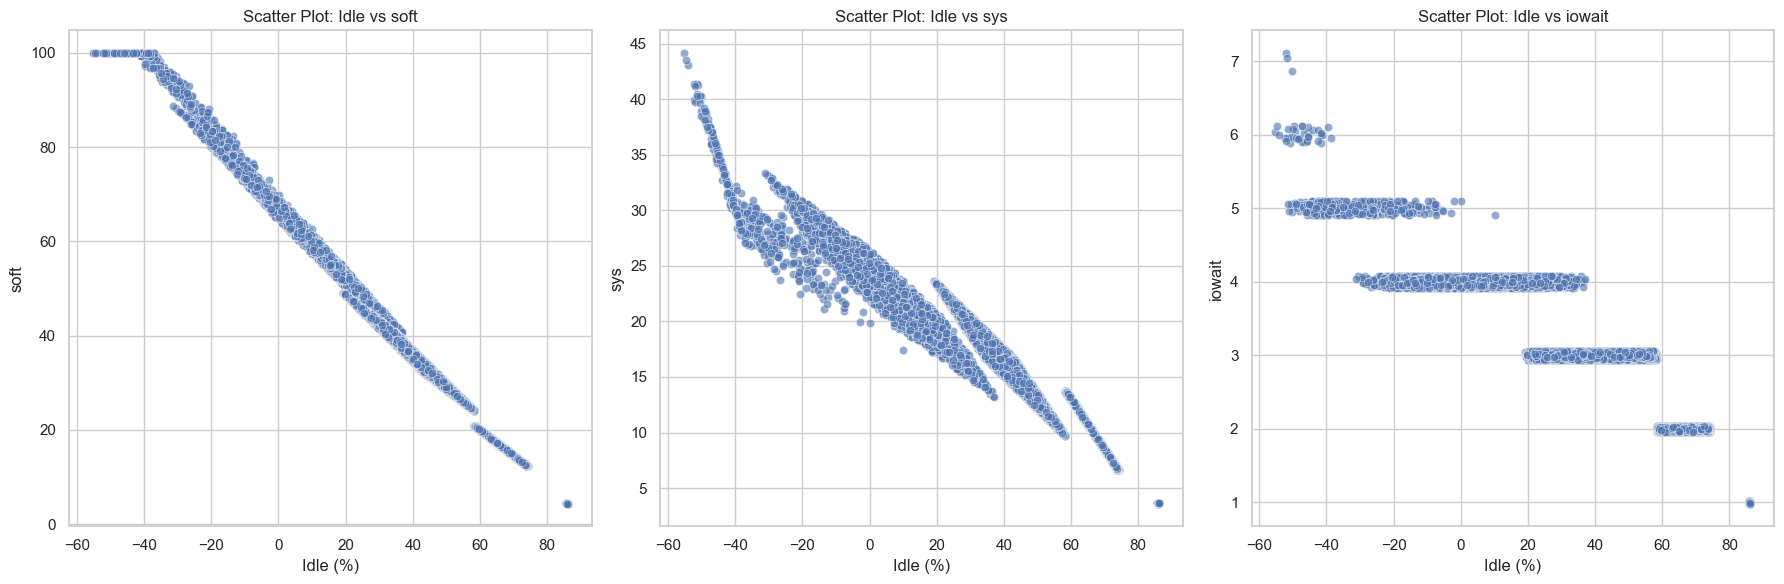

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
metrics_to_plot = ['soft', 'sys', 'iowait']

for ax, metric in zip(axes, metrics_to_plot):
    sns.scatterplot(data=linux_records, x='idle', y=metric, ax=ax, alpha=0.6)
    ax.set_title(f'Scatter Plot: Idle vs {metric}')
    ax.set_xlabel('Idle (%)')
    ax.set_ylabel(f'{metric}')

plt.tight_layout()
plt.show()

1. idle vs soft: the diagram shows a very strong negative correlation between the two. While ide decreases, soft increases, indicating that when the CPU is busier with soft tasks, there is less idle time available. The relationship seems to be linear.
2. idle vs sys: here too is a strong and linear negative correlation, suggesting that an increase in system activity is associated with a decrease in CPU idle time.
3. idle vs iowait: here the relationship is different. As you can see there are several horizontal bands which suggest that there are levels of 'iowait' for which the CPU is inactive. This may indicate that I/O wait times are recorded in intervals.

Interestingly, when the idle displays negative values, all three graphs exhibit anomalies. This is particularly clear in the first graph, when a collection of points appears on the idle axis negative area. This can represent errors in measurement or data capture.

These charts lead us to the conclusion that negative idle time is probably an indication of data issues and has to be handled carefully. We will deal with this problem by removing all rows containing negative values ​​for the 'idle' column because it maintains the integrity of the remaining data, without introducing new values ​​that could distort the true distribution, and the volume of negative data is very small compared to the total.


Removing rows with negative values

In [10]:
linux_records = linux_records[linux_records['idle'] >= 0]
len(linux_records.index)

481295

# Analyzing 'mem_used' column
- Histogram
- Boxplot
- Statistics
- Potential impact on other metrics 

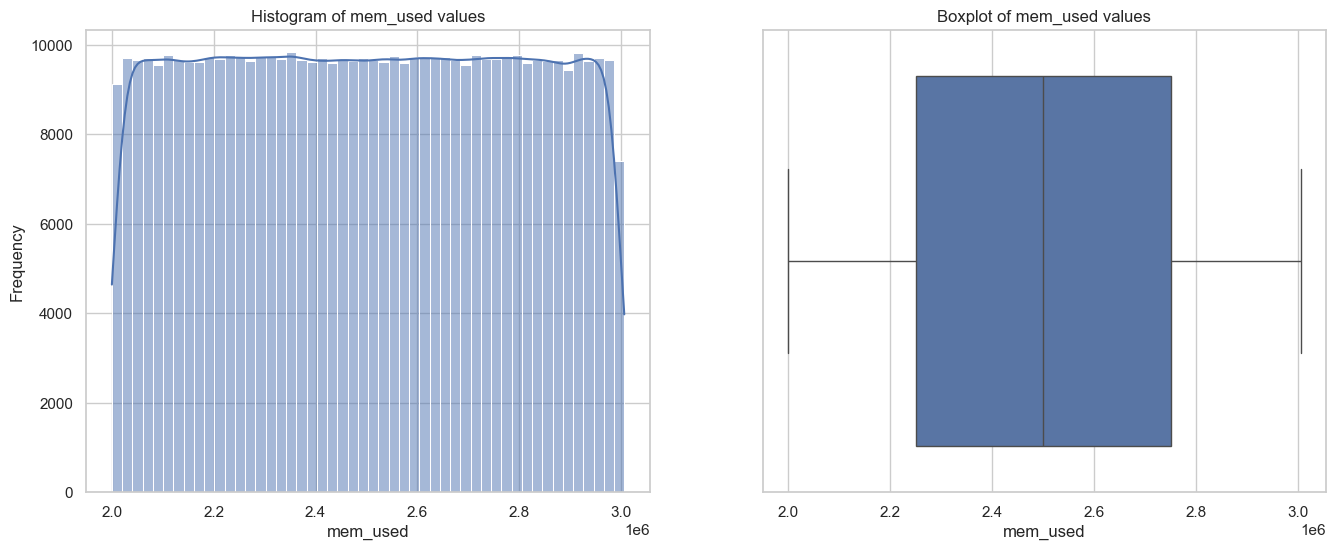

In [11]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1,2, figsize=(16,6))

# histogram for 'mem_used'
sns.histplot(linux_records['mem_used'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Histogram of mem_used values')
ax[0].set_xlabel('mem_used')
ax[0].set_ylabel('Frequency')

# boxplot for 'idle'
sns.boxplot(x=linux_records['mem_used'], ax=ax[1])
ax[1].set_title('Boxplot of mem_used values')
ax[1].set_xlabel('mem_used')

plt.show()

These two graphs, as above, analyze the distribution of values ​​for 'mem_used'.

For the histogram:
- a even distribution of values ​​is observed with a slight tilt to the left.
- most values ​​are concentrated at the top of the range, with less frequency as we approach lower values
- there is no wide variation in values, indicating a consistency of memory usage across the dataset

For the boxplot:
- the values are concentrated around the median
- the variations in mem_used are not extreme




In [12]:
subset_correlation_matrix = linux_records.iloc[:10000].corr()
subset_idle_correlations = subset_correlation_matrix['mem_used'].sort_values()
subset_idle_correlations

mem_available      -1.000000
mem_free           -1.000000
record_timestamp   -0.019192
swap_free          -0.017246
idle               -0.016669
nice               -0.012519
sda1               -0.004467
tmpfs_root         -0.004467
usr                -0.001414
mem_buffcached      0.001868
cs_root             0.002689
mem_shared          0.006343
sys                 0.014187
iowait              0.016656
swap_used           0.017246
soft                0.017591
mem_used            1.000000
devtmpfs                 NaN
irq                      NaN
steal                    NaN
guest                    NaN
mem_total                NaN
swap_total               NaN
Name: mem_used, dtype: float64

These correlations give us a detailed look at how 'mem_used' is related to other metrics in the dataset.

1. Perfect Correlations:
- mem_available
- mem_free

Because as the memory used increases the amount of available or free memory would decrease.

2. Reduced Correlations:
record_timestamp   -0.019192
swap_free          -0.017246
idle               -0.016669
nice               -0.012519
sda1               -0.004467
tmpfs_root         -0.004467
usr                -0.001414
mem_buffcached      0.001868
cs_root             0.002689
mem_shared          0.006343
sys                 0.014187
iowait              0.016656
swap_used           0.017246
soft                0.017591

This suggests that there is not a strong linear relationship between these metricds and memory usage.

3. Zero Correlations:
devtmpfs                 NaN
irq                      NaN
steal                    NaN
guest                    NaN
mem_total                NaN
swap_total               NaN

It means that there is no variation in these data or they are constant and no correlation can be calculated.



# Analyzing 'sys' column
- Histogram
- Boxplot

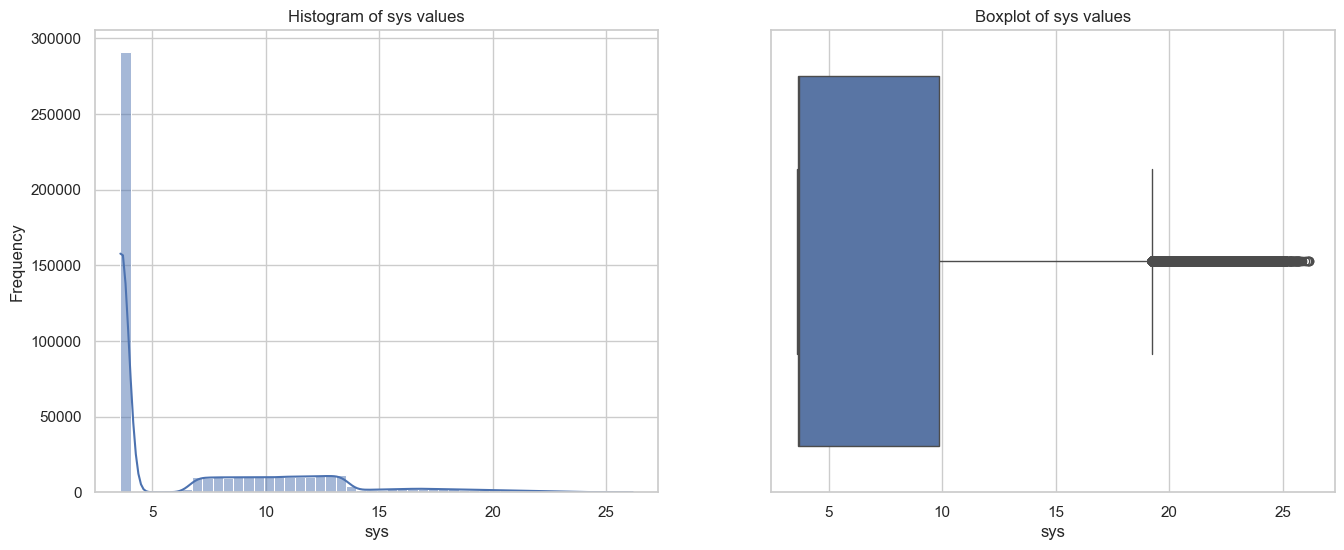

In [14]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1,2, figsize=(16,6))

# histogram for 'sys'
sns.histplot(linux_records['sys'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Histogram of sys values')
ax[0].set_xlabel('sys')
ax[0].set_ylabel('Frequency')

# boxplot for 'sys'
sns.boxplot(x=linux_records['sys'], ax=ax[1])
ax[1].set_title('Boxplot of sys values')
ax[1].set_xlabel('sys')

plt.show()

Judging by these 2 graphs, the possible value of a threshold for 'sys' so that the system presents an error would be somewhere between 10-15